Learn the inter-grid operator ratio for homogeneous problems using multigrid framework, dataset is constructed by changing RHS 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import h5py
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshHandler
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet
from Utils import plot

In [2]:
class RHSDataSet(Dataset):
    def __init__(self, h5file, case='train', transform=None, target_transform=None):
        """
        case = 'train' or 'test'
        """
        h5 = h5py.File(h5file,'r')
        self.data = np.array(h5[case], dtype=np.float32)
        self.totensor = ToTensor()
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        rhs_tensor = self.totensor(self.data[idx])
        if self.transform:
            rhs_tensor = self.transform(rhs_tensor)
        return rhs_tensor

In [3]:
training_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='train')
test_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='test')

train_dataloader = DataLoader(training_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

In [4]:
#for i, data in enumerate(train_dataloader):
#    img = data
#    print(img.shape)

In [5]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.property = [1, 1] # homogeneous problem
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshHandler(size, prop=self.property, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = self.jac.jacobi_convolution(v, f, n_iter=num_sweeps_down)
        return v


In [6]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n = 64):
        super(MultiGrid, self).__init__()

        # Hyper parameters
        self.m = 10 # number of iterations to compute q

        # Problem parameters
        self.size = 2
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.solution = []
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        # Kernels for inter-grid communication 
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, bias=False) # restriction
        restriction_kernel = torch.asarray([[1, 2, 1],
                                            [2, 4, 2],
                                            [1, 2, 1]], dtype=torch.float32) / 16.0
        self.conv.weight = nn.Parameter(restriction_kernel.reshape(1,1,3,3))
        self.conv.requires_grad_(False)

        self.deconv = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1, bias=False) # interpolation
        interpolation_kernel = torch.asarray([[1, 2, 1],
                                              [2, 4, 2],
                                              [1, 2, 1]], dtype=torch.float32) / 4.0
        interpolation_kernel = interpolation_kernel #+ torch.randn((3,3))
        self.deconv.weight = nn.Parameter(interpolation_kernel.reshape(1,1,3,3))
        # self.deconv.requires_grad_(True)
        self.deconv.requires_grad_(False)

        self.w = torch.asarray([5.,2.], dtype=torch.float32)
        self.w.requires_grad_(True)
    
    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        '''
        rFC = self.conv(rF[:, :, 1:-1, 1:-1].clone())
        rFC = F.pad(rFC,(1,1,1,1),"constant",0) # pad the coarse-level residual with zeros
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def qm(self, x):
        "Compute the convergence factor after m iterations"
        res1 = self.f - self.grids[0].Knet(x)
        res0 = self.f - self.grids[0].Knet(self.v)
        return torch.mean(torch.pow(torch.norm(res1[:, :, 1:-1, 1:-1].clone(), dim=(2,3))/torch.norm(res0[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).detach(), 1.0/self.m))
    
    def forward(self, F):
        '''Input is RHS field F'''
        self.f = self.grids[0].fnet(F) # assign the finest rhs 
        self.v = torch.zeros_like(F, requires_grad=False, dtype=torch.float32) # initial solution
        U = torch.clone(self.v)
    
        for i in range(self.m-1):
            U = self.iterate(U).detach()
        return self.iterate(U)

    def iterate(self, x):
        '''Input x is the initial solution on the finest grid'''
        n_batches = x.shape[0]
        n_relax = 1 # number of relaxations
        self.grids[0].v = x
        self.grids[0].f = self.f
        self.grids[0].v = self.grids[0].Relax(self.grids[0].v, self.grids[0].f, n_relax)

        for j in range(0, self.L-1):
            rF = self.grids[j].f-self.grids[j].Knet(self.grids[j].v)
            self.grids[j+1].f = self.w[0]*self.Restrict(rF)
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False)
            self.grids[j+1].v = self.grids[j+1].Relax(self.grids[j+1].v, self.grids[j+1].f, n_relax)

        self.grids[self.L-1].v = self.grids[self.L-1].Relax(self.grids[self.L-1].v, self.grids[self.L-1].f, n_relax)

        for j in range(self.L-2,-1,-1):
            error_delta = self.w[1]*self.Interpolate(self.grids[j+1].v)
            self.grids[j].v = self.grids[j].v + error_delta
            self.grids[j].v = self.grids[j].Relax(self.grids[j].v, self.grids[j].f, n_relax)

            # zero out the previous level solution
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False) 

        return self.grids[0].v 

In [7]:
n = 2**4
model = MultiGrid(n)
rhs = next(iter(train_dataloader))

0 0.6876073479652405
1 3.472623586654663
2 22.423423767089844
3 148.19264221191406
4 980.549560546875
5 6486.67333984375
6 42906.61328125
7 283798.5625
8 1877117.25
9 12415700.0
10 82120360.0
11 543163072.0
12 3592606464.0
13 23762339840.0
14 157169631232.0
15 1039556804608.0
16 6875868823552.0
17 45478582419456.0
18 300805953421312.0
19 1989598771150848.0
20 1.3159669199536128e+16
21 8.704112002596864e+16
22 5.757097858616525e+17
23 3.8078773227033723e+18
24 inf
25 inf
26 inf
27 inf
28 inf
29 inf
30 inf
31 inf
32 inf
33 inf
34 inf
35 inf
36 inf
37 inf
38 inf
39 inf
40 inf
41 inf
42 inf
43 inf
44 inf
45 inf
46 inf
47 nan
Solution converges after 48 multi-grid iterations 


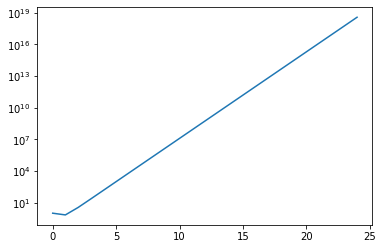

In [8]:
EPS = 5e-5
n_twogrid = 0
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[0].unsqueeze(0))
while (abs(res) > EPS):
    u = model.iterate(u)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_twogrid, res)
    n_twogrid += 1

print("Solution converges after", n_twogrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')

In [9]:
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.deconv.weight
optimizer = torch.optim.Adam([model.w], lr=1e-3)
model.w

tensor([5., 2.], requires_grad=True)

In [10]:
def train_one_epoch():
    running_loss = 0.
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad() # zero the gradients for every batch
        u_out = model(data)
        loss_q = model.qm(u_out)
        
        loss_q.backward()
        optimizer.step()
        running_loss += loss_q.item()
    
    last_loss = running_loss/(i+1)
    return last_loss

In [11]:
model_dir = 'Model/multigrid_rhs'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

num_epoch = 200
best_vloss = 1_000_000.

qm_train = []
for epoch in range(num_epoch):
    model.train(True)
    avg_q = train_one_epoch()
    print(epoch, avg_q)
    
    # Track best performance, and save the model's state
    mpath = os.path.join(model_dir,'model_multigrid_poisson.pth')
    torch.save(model.state_dict(), mpath)
    qm_train.append(avg_q)

print("\nNew value:")
model.conv.weight
model.deconv.weight
model.w

0 4.966578811407089
1 4.801218897104263
2 4.645296275615692
3 4.493453830480576
4 4.342696934938431
5 4.200976133346558
6 4.068015962839127
7 3.932392418384552
8 3.800277143716812
9 3.679984971880913
10 3.562734752893448
11 3.439998537302017
12 3.3356751054525375
13 3.2271803468465805
14 3.116522654891014
15 3.017900228500366
16 2.91802941262722
17 2.8261207938194275
18 2.734622895717621
19 2.6476771235466003
20 2.555348366498947
21 2.473028600215912
22 2.3905504941940308
23 2.3091896027326584
24 2.235831156373024
25 2.1565050035715103
26 2.0911818891763687
27 2.021681472659111
28 1.950993500649929
29 1.8859239220619202
30 1.8243725821375847
31 1.761155605316162
32 1.7001161202788353
33 1.6381282806396484
34 1.5869733095169067
35 1.528289645910263
36 1.4774789959192276
37 1.422302134335041
38 1.3748829886317253
39 1.3257248848676682
40 1.2780668810009956
41 1.2275618612766266
42 1.1833620592951775
43 1.137711301445961
44 1.0966799519956112
45 1.0559744983911514
46 1.0144685991108418
47

tensor([4.1921, 1.1026], requires_grad=True)

Text(0.5, 0, 'epoch')

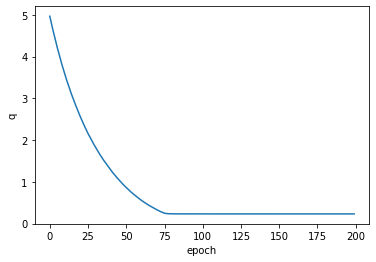

In [18]:
plt.plot(qm_train)
plt.ylabel('q')
plt.xlabel('epoch')

In [21]:
EPS = 5e-5
n_twogrid = 0
n = 2**4
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[0].unsqueeze(0))
while (abs(res) > EPS):
    u = model.iterate(u)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_twogrid, res)
    n_twogrid += 1

print("Solution converges after", n_twogrid, "multi-grid iterations ")

0 0.07821792364120483
1 0.014078252017498016
2 0.002601317595690489
3 0.0005011418252252042
4 0.00010184512211708352
5 2.1579424355877563e-05
Solution converges after 6 multi-grid iterations 


In [22]:
# Test the multigrid iteration
class Multigrid():
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):
        # Problem parameters
        C = 0.0
        k = 1
        l = 2

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.w = inter_model.w.detach()
        self.restrict_kernel = inter_model.conv.weight.detach()
        self.interpolate_kernel = inter_model.deconv.weight.detach()
        
        u_exact = C/(np.power(np.pi*k,2)+np.power(np.pi*l,2))*np.sin(k*np.pi*self.xx)*np.sin(l*np.pi*self.yy)  # exact solution
        self.u_exact = torch.from_numpy(u_exact.reshape(1,1,n+1, n+1))

        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = C*np.sin(k*np.pi*self.xx)*np.sin(l*np.pi*self.yy)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs

    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, f):
        '''
        Perform full weighting operation to down sample to next level
        '''
        f_res = f[:, :, 1:-1, 1:-1]
        f_res = F.conv2d(f_res, self.restrict_kernel, stride=2)
        #f_res = F.conv2d(f_res, self.restrict_kernel, stride=2)
        return F.pad(f_res,(1,1,1,1),"constant",0) # pad with zeros

    def Interpolate(self, v):
        '''
        Perform linear interpolation and upsample to previous level ==> Return size: (2*N - 1), Ex. 17 -> 33
        '''
        v = F.conv_transpose2d(v, self.interpolate_kernel, stride=2, padding=1)
        #v = F.conv_transpose2d(v, self.interpolate_kernel, stride=2, padding=1)
        return v

    def Error(self,v):
        '''
        Compute the error between current approximation and exact solution
        v should be a 1D vector
        '''
        return torch.linalg.norm(v.reshape(-1)-self.u_exact.reshape(-1), ord=torch.inf)
    
    def rec_V_cycle(self, l, v, f):
        '''
        Perform recursive V-cycle
        Input: l, current level
        '''
        n_sample = 1
        self.grids[l].v = v
        self.grids[l].f = f
        self.grids[l].v = self.grids[l].Relax(v, f, n_sample)
        if(not self.grids[l].IsCoarsest()):
            residual = self.grids[l].f-self.grids[l].Knet(self.grids[l].v)
            self.grids[l+1].f = self.w[0]*self.Restrict(residual)
            self.grids[l+1].v *= 0.
            self.rec_V_cycle(l+1, self.grids[l+1].v, self.grids[l+1].f)
            self.grids[l].v += self.w[1]*self.Interpolate(self.grids[l+1].v)
            self.grids[l+1].v *= 0.
        
        self.grids[l].v = self.grids[l].Relax(self.grids[l].v,self.grids[l].f,n_sample) 

    def Solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.randn((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.rec_V_cycle(0,self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

10.247034431395274 6.515786170959473
5.217282916439157 1.0188381671905518
4.161444106742582 0.1960575431585312
3.7928598689261417 0.041264817118644714
3.594055998920874 0.00908931065350771
3.5203228974254412 0.0020592259243130684
3.5400813262333095 0.000474970176583156
3.620960030114508 0.00011086874292232096
3.7179941811848263 2.60918586718617e-05
Solution converges after 9 V-cycle iterations with relative error of 3.7179941811848263


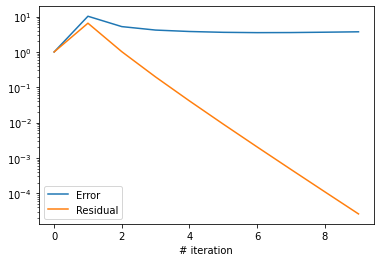

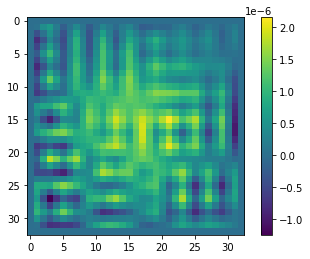

In [23]:
# Multigrid implementation
n = 2**5
prob_mg = Multigrid(model, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.Solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())